In [29]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate

In [30]:
tf.config.experimental.list_physical_devices(device_type='GPU')

2023-11-22 10:43:50.351585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 10:43:50.390121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 10:43:50.390292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
def json_to_dataset(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.head())
    f.close()
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    #df = df.iloc[:10000]
    print(df.columns)
    print(df.head)
    dataset = Dataset.from_pandas(df)
    dataset = dataset.train_test_split(test_size=0.2)
    return dataset

In [32]:
train_data = json_to_dataset('Train_Headline_Generation.json')

                                                news  \
0  (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...   
1  (Oct 29, 2013  8:15 AM CDT) Dax Shepard and Kr...   
2  (Mar 6, 2016  10:50 AM) Nancy Reagan, the help...   
3  (Aug 15, 2008  5:11 AM CDT) American Airlines ...   
4  (Apr 18, 2016  1:02 PM CDT) Ingrid Lyne, the S...   

                                            headline  
0   30K Walmart Part-Timers to Lose Health Insurance  
1     Dax Shepard: Wedding to Kristen Bell Cost $142  
2                            Nancy Reagan Dead at 94  
3  American Airlines Faces $7M Fine for Safety Vi...  
4   $222K Raised for Kids of Mom Dismembered on Date  
Index(['news', 'headline'], dtype='object')
<bound method NDFrame.head of                                                     news  \
0       As of Jan. 1, Walmart will no longer offer 30...   
1       Dax Shepard and Kristen Bell got married at t...   
2       Nancy Reagan, the helpmate, backstage adviser...   
3       American Ai

In [2]:
model_name = "Michau/t5-base-en-generate-headline"

In [5]:
prefix = "headline: "
#max_len = 3024
max_len = 2024
#max_l = 1028
max_l = 256

In [6]:
def preprocess_function(examples):   
    inputs = [prefix + doc for doc in examples["news"]]
    model_inputs = tokenizer(inputs, max_length=max_len, truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=max_l, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

To apply the preprocess function over the entire dataset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [11]:
tokenized = train_data.map(preprocess_function, batched=True, num_proc=4,
                        remove_columns=train_data['train'].column_names)

Map (num_proc=4):   0%|          | 0/16925 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4232 [00:00<?, ? examples/s]

In [12]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

In [13]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

2023-11-21 21:01:49.306459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0
2023-11-21 21:01:49.308234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:c1:00.0, compute capability: 7.0
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Michau/t5-base-en-generate-headline.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


To convert datasets to the tf.data.Dataset format 

In [14]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [15]:
model.compile(optimizer=optimizer)

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(x=tf_train_set, validation_data=tf_test_set, callbacks=[callback], batch_size=6, epochs=7)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/7
1057/1057 [==============================] - 645s 587ms/step - loss: 2.1624 - val_loss: 1.8009
Epoch 2/7
1057/1057 [==============================] - 616s 583ms/step - loss: 1.8648 - val_loss: 1.7330
Epoch 3/7
1057/1057 [==============================] - 617s 584ms/step - loss: 1.6920 - val_loss: 1.6944
Epoch 4/7
1057/1057 [==============================] - 617s 584ms/step - loss: 1.5527 - val_loss: 1.6818
Epoch 5/7
1057/1057 [==============================] - 617s 584ms/step - loss: 1.4353 - val_loss: 1.6784
Epoch 6/7
1057/1057 [==============================] - 649s 614ms/step - loss: 1.3329 - val_loss: 1.6855


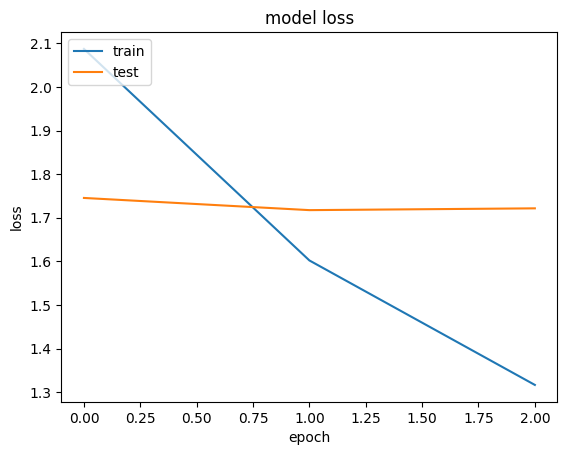

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
f = open('Dev_Headline_Generation.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
#df = df.iloc[45:50]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [19]:
def t5_predictions(data, tokenizer, model):
    text = prefix + data['news']
    inputs = tokenizer.encode_plus(text, return_tensors="pt").input_ids

    outputs = model.generate(inputs,
                              max_length = 64, num_beams = 5, early_stopping = True)
    predictions = tokenizer.decode(outputs[0])
    result = re.sub("\<.*?\>","", predictions)
    return result

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [24]:
rouge = evaluate.load("rouge")

In [20]:
predictions = [t5_predictions(i, tokenizer, model) for i in test_data]

2023-11-21 22:04:49.097731: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f88c806d3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-21 22:04:49.097771: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-21 22:04:49.097778: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-21 22:04:49.101719: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-21 22:04:49.123127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-11-21 22:04:49.130143: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

In [21]:
df = pd.DataFrame()
df['predictions'] = predictions
df.head()

,predictions
0,3 Killed in California Quarry Shooting Spree
1,Dow Up 305 on Election Day
2,The Interview Is Now Available for $14.99
3,10-Year-Old Accused of Killing 90-Year-Old Wo...
4,Tobacco Companies Discovered Radiation in 1959


In [22]:
df.to_excel('hpc_michau21.xlsx')

In [12]:
df = pd.read_excel('hpc_michau21.xlsx')

In [13]:
df['answers'] = test_data['headline']
df.head()

,Unnamed: 0,predictions,answers
0,0,3 Killed in California Quarry Shooting Spree,3rd Victim Dead in Quarry Shooting; Manhunt St...
1,1,Dow Up 305 on Election Day,Stocks Up 305 in Election Rally
2,2,The Interview Is Now Available for $14.99,You Can Watch The Interview at 1pm
3,3,10-Year-Old Accused of Killing 90-Year-Old Wo...,"Murder Suspect, 10, Will Stay in Adult Jail"
4,4,Tobacco Companies Discovered Radiation in 1959,Tobacco Firms Knew of Radiation in Cigs—in 1959


In [14]:
rouge = evaluate.load("rouge")

In [15]:
def compute_rouge(data):
    rougescore = rouge.compute(predictions=[data['predictions']], references=[data['answers']])
    return rougescore

In [16]:
df['rougescores'] = df.apply(lambda x: rouge.compute(predictions=[x['predictions']], references=[x['answers']]), axis=1)

In [24]:
df['rougescores'] = [d.get('rougeL') for d in df['rougescores']]
len(df.loc[df['rougescores']==1])

30

In [25]:
len(df.loc[df['rougescores']>=0.5])

687

In [26]:
len(df.loc[df['rougescores']>=0.75])

177

In [20]:
from evaluate import load
bertscore = load("bertscore")

In [21]:
df['bertscores'] = df.apply(lambda x: bertscore.compute(predictions=[x['predictions']], references=[x['answers']],
                                                       rescale_with_baseline=True, lang="en", batch_size=1), axis=1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
df['bert_f1'] = [d.get('f1')[0] for d in df['bertscores']]
df.head()

,Unnamed: 0,predictions,answers,rougescores,rougeL,bertscores,bert_f1
0,0,3 Killed in California Quarry Shooting Spree,3rd Victim Dead in Quarry Shooting; Manhunt St...,"{'rouge1': 0.375, 'rouge2': 0.1428571428571428...",0.375000,"{'precision': [0.4577317535877228], 'recall': ...",0.351130
1,1,Dow Up 305 on Election Day,Stocks Up 305 in Election Rally,"{'rouge1': 0.5, 'rouge2': 0.20000000000000004,...",0.500000,"{'precision': [0.371025413274765], 'recall': [...",0.285281
2,2,The Interview Is Now Available for $14.99,You Can Watch The Interview at 1pm,"{'rouge1': 0.26666666666666666, 'rouge2': 0.15...",0.266667,"{'precision': [0.17242328822612762], 'recall':...",0.126363
3,3,10-Year-Old Accused of Killing 90-Year-Old Wo...,"Murder Suspect, 10, Will Stay in Adult Jail","{'rouge1': 0.2727272727272727, 'rouge2': 0.1, ...",0.272727,"{'precision': [0.28607577085494995], 'recall':...",0.349638
4,4,Tobacco Companies Discovered Radiation in 1959,Tobacco Firms Knew of Radiation in Cigs—in 1959,"{'rouge1': 0.5333333333333333, 'rouge2': 0.307...",0.533333,"{'precision': [0.5810285210609436], 'recall': ...",0.440258


In [28]:
df.to_excel('sub2_michal.xlsx')